(assign3_solution)=
# Assignment 3: Brightness temperature difference map

from the original MYD03 and a ch30 file containing channel 30 radiances
copied and scaled from a MYD031KM file

In [1]:
import json
import pdb
import pprint
import shutil
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import h5py
import a301_lib
import sys
from pyresample import kd_tree
from sat_lib.modismeta_read import get_core, parseMeta
from sat_lib.radiation import planck_invert
from sat_lib.modis_chans import chan_dict

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init


## new function planck_invert

In [2]:
help(planck_invert)

Help on function planck_invert in module sat_lib.radiation:

planck_invert(wavel, Lstar)
    Calculate the brightness temperature
    
    Parameters
    ----------
    
      wavel: float
           wavelength (meters)
    
      Lstar: float or array
           Blackbody radiance (W/m^2/m/sr)
    Returns
    -------
    
    Tbright:  float or arr
           brightness temperature (K)



## new dictionary chan_dict

In [3]:
chan_dict

{'1': {'field_name': 'EV_250_Aggr1km_RefSB',
  'wavelength_um': [0.62, 0.67],
  'index': 0,
  'scale': 'reflectance_scales',
  'units': 'none',
  'offset': 'reflectance_offsets'},
 '2': {'field_name': 'EV_250_Aggr1km_RefSB',
  'wavelength_um': [0.841, 0.876],
  'index': 1,
  'scale': 'reflectance_scales',
  'units': 'none',
  'offset': 'reflectance_offsets'},
 '3': {'field_name': 'EV_500_Aggr1km_RefSB',
  'wavelength_um': [0.459, 0.479],
  'index': 0,
  'scale': 'reflectance_scales',
  'units': 'none',
  'offset': 'reflectance_offsets'},
 '4': {'field_name': 'EV_500_Aggr1km_RefSB',
  'wavelength_um': [0.545, 0.565],
  'index': 1,
  'scale': 'reflectance_scales',
  'units': 'none',
  'offset': 'reflectance_offsets'},
 '5': {'field_name': 'EV_500_Aggr1km_RefSB',
  'wavelength_um': [1.23, 1.25],
  'index': 2,
  'scale': 'reflectance_scales',
  'units': 'none',
  'offset': 'reflectance_offsets'},
 '6': {'field_name': 'EV_500_Aggr1km_RefSB',
  'wavelength_um': [1.628, 1.652],
  'index': 3,


## Find the files in the sat_data.h5_dir

In [4]:
geom_filelist = list(a301_lib.sat_data.glob("h5_dir/geom*2105*h5"))
rad_filelist = list(a301_lib.sat_data.glob("h5_dir/oct9*2105*h5"))

In [5]:
geom_file_name = geom_filelist[0]
print(geom_file_name)
rad_file_name = rad_filelist[0]
print(rad_file_name)

/home/phil/work/sat_data/h5_dir/geom_MYD03.A2013222.2105.006.2013223155808.h5
/home/phil/work/sat_data/h5_dir/oct9_MYD021KM.A2013222.2105.061.2018047235850.h5


## Read the latitudes and longitudes

Also read the core metadata to get the swath corners

In [6]:
with h5py.File(geom_file_name,'r') as f:
    print(list(f.keys()))
    geom_group = f['geometry']
    print(list(geom_group.keys()))
    lats = geom_group['latitude'][...]
    print(lats.shape)
    lons = geom_group['longitude'][...]
    print(lons.shape)
    print(f.attrs.keys())
    core_metadata = f.attrs["CoreMetadata.0"]
    swath_info = parseMeta(core_metadata)

['geometry']
['latitude', 'longitude']
(2040, 1354)
(2040, 1354)
<KeysViewHDF5 ['CoreMetadata.0', 'history']>


## get the central wavelengths from chan_dict

From the {ref}`modis_level1` notebook, look in the https://modis.gsfc.nasa.gov/abou#t/specifications.php

In [7]:
chan31_mid = (chan_dict['31']['wavelength_um'][0] + chan_dict['31']['wavelength_um'][1])/2.
chan32_mid = (chan_dict['32']['wavelength_um'][0] + chan_dict['32']['wavelength_um'][1])/2.
print(f"mid-channel wavelengths: {chan31_mid}, {chan32_mid}")

mid-channel wavelengths: 11.03, 12.02


## Read the channel 31/32 radiances

In [8]:
with h5py.File(rad_file_name,'r') as f:
    print(list(f.keys()))
    channel_group = f['channels']
    print(list(channel_group.keys()))
    ch31 = channel_group['chan31'][...]
    ch32 = channel_group['chan32'][...]
    print(ch31.shape)

['channels']
['chan30', 'chan31', 'chan32']
(2040, 1354)


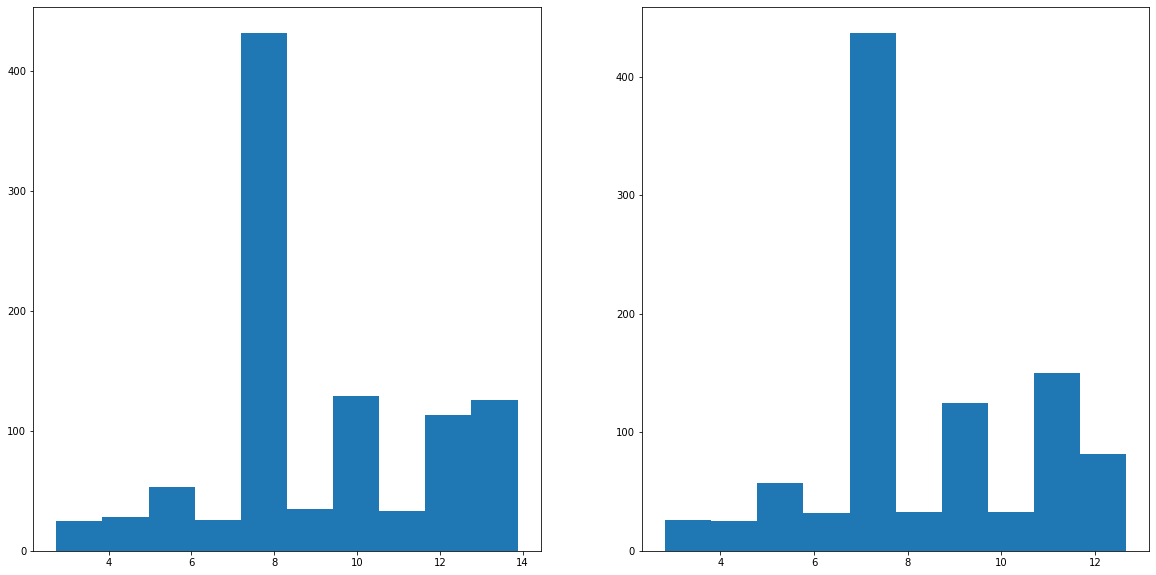

In [9]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].hist(ch31.flat[:1000])
ax[1].hist(ch32.flat[:1000]);

## Convert to brightness temperatures

In [10]:
#help(planck_invert)

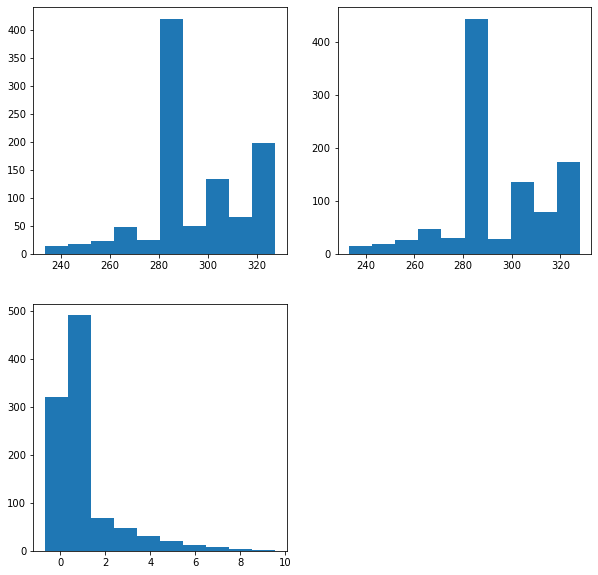

In [11]:
T31 = planck_invert(chan31_mid*1.e-6, ch31*1.e6)
T32 = planck_invert(chan32_mid*1.e-6, ch32*1.e6)
Tdiff = T31 - T32
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].hist(T31.flat[:1000])
ax[0,1].hist(T32.flat[:1000])
ax[1,0].hist(Tdiff.flat[:1000]); 
fig.delaxes(ax[1,1])

## Make the map

## Now resample

pyresample needs proj4 map parameters to put together its grid.  These are
returned by the get_proj_params file below.

In [12]:
def get_proj_params(swath_info):
    """
    given a swath_info dictionary return proj4 parameters
    for use by cartopy or pyresample, assuming a laea projection
    and WGS84 datum
    
    Parameters
    ----------
    
    swath_info:  dictionary
       returned by modismeta_read
    
    Returns
    -------
    
    proj_params: dict
        dict with parameters for proj4
        
    """
    import cartopy.crs as ccrs

    globe_w = ccrs.Globe(datum="WGS84", ellipse="WGS84")
    projection_w = ccrs.LambertAzimuthalEqualArea(
        central_latitude=swath_info["lat_0"],
        central_longitude=swath_info["lon_0"],
        globe=globe_w,
    )
    proj_params = projection_w.proj4_params
    return proj_params

In [13]:
proj_params =get_proj_params(swath_info)
print(f"proj_params: {proj_params}")

proj_params: {'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'laea', 'lon_0': -121.4046532375215, 'lat_0': 39.59930047125515, 'x_0': 0.0, 'y_0': 0.0}


* Use pyresample to define a new grid in this projection

In [14]:
from pyresample import load_area, save_quicklook, SwathDefinition

proj_params = get_proj_params(swath_info)
swath_def = SwathDefinition(lons, lats)
area_def = swath_def.compute_optimal_bb_area(proj_dict=proj_params)

/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [15]:
print(area_def)

Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.5993004712551', 'lon_0': '-121.404653237522', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2534
Number of rows: 2244
Area extent: (-1269189.1278, -1177871.0124, 1531795.604, 1265796.0146)


/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


* resample ch30 on this grid

In [16]:
fill_value = -9999.0
area_name = "modis swath 5min granule"
image_Tdiff = kd_tree.resample_nearest(
    swath_def,
    Tdiff.ravel(),
    area_def,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
print(f"\ndump area definition:\n{area_def}\n")
print(
    (
        f"\nx and y pixel dimensions in meters:"
        f"\n{area_def.pixel_size_x}\n{area_def.pixel_size_y}\n"
    )
)


dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.5993004712551', 'lon_0': '-121.404653237522', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2534
Number of rows: 2244
Area extent: (-1269189.1278, -1177871.0124, 1531795.604, 1265796.0146)


x and y pixel dimensions in meters:
1105.3609833643736
1088.9781760558744



* replace missing values with floating point nan

In [17]:
nan_value = np.array([np.nan], dtype=np.float32)[0]
image_Tdiff[image_Tdiff < -9000] = nan_value

## Plot the image using cartopy

* Create a palette

We want to spread the colors over a limited range of values between 0.1 and 7 W/m^2/microns/sr so we
will set over and under colors and normalize the data to this range

 Some links about colors:

* [rods, cones and rgb](https://theneurosphere.com/2015/12/17/the-mystery-of-tetrachromacy-if-12-of-women-have-four-cone-types-in-their-eyes-why-do-so-few-of-them-actually-see-more-colours/)

* [matplotlib palettes](https://matplotlib.org/examples/color/colormaps_reference.html)

* [xkcd color survey](https://blog.xkcd.com/2010/05/03/color-survey-results/)

* [xkcd colors from matplotlib](https://seaborn.pydata.org/generated/seaborn.xkcd_palette.html)

* [wikipedia article on RGB colors](https://en.wikipedia.org/wiki/RGB_color_model)

In [18]:
import copy
pal = copy.copy(plt.get_cmap("plasma"))
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("r")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
vmin = 0.
vmax = 3.0
from matplotlib.colors import Normalize

the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)

* use the palette on the Tdiff array

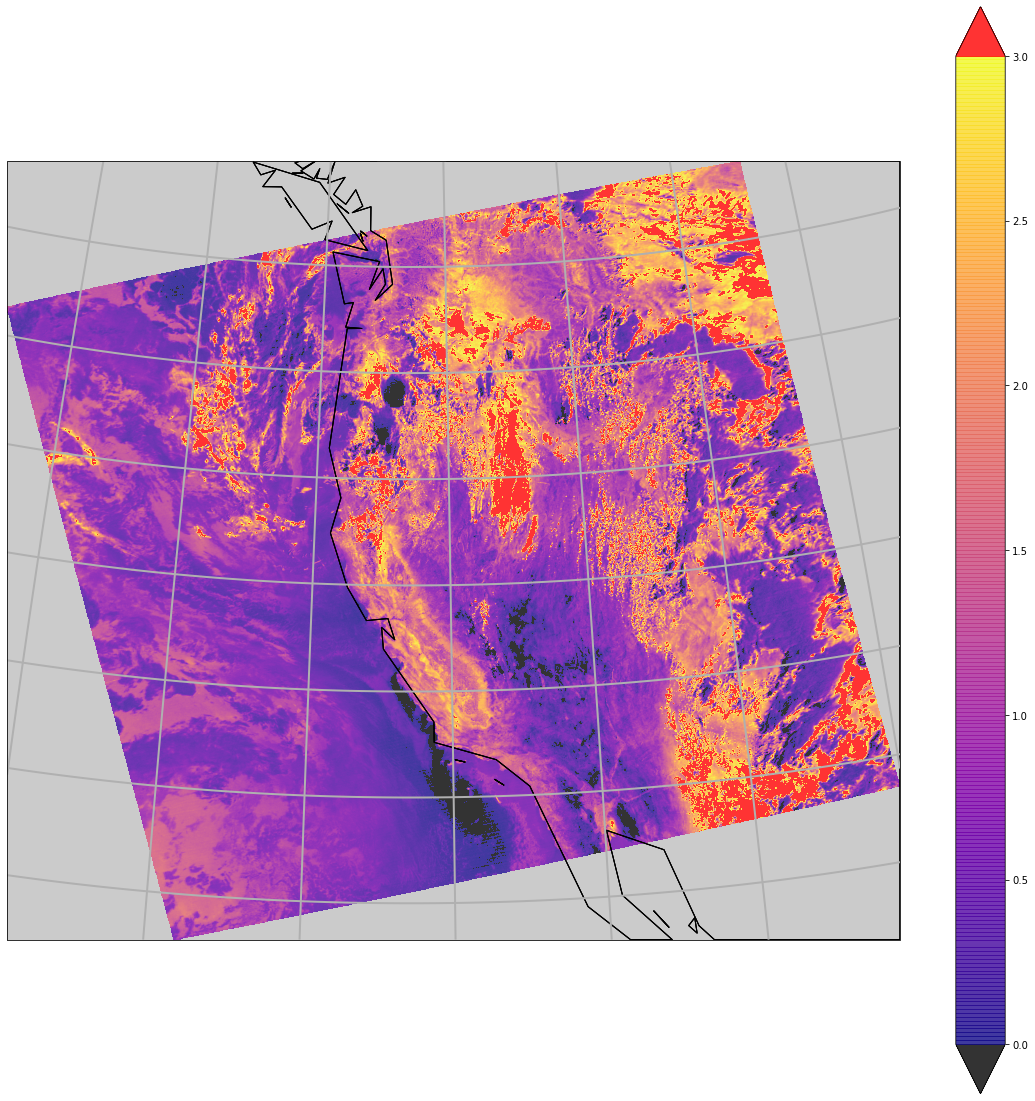

In [19]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(1, 1, figsize=(20,20), subplot_kw={"projection": crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
ax.set_extent(crs.bounds, crs)
cs = ax.imshow(
    image_Tdiff,
    transform=crs,
    extent=crs.bounds,
    origin="upper",
    alpha=0.8,
    cmap=pal,
    norm=the_norm,
)
fig.colorbar(cs, extend="both");

* write out all the projection information as a json file

Make a new folder to hold this, along with the resampled image written as
a [numpy npz file](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

In that folder, also write out a json file with all the metadata

In [20]:
out_dict = {}
out_dict["proj_params"] = crs.proj4_params
out_dict["extent"] = crs.bounds
globe = crs.globe.to_proj4_params()
out_dict["globe"] = dict(globe)
out_dict["metadata"] = swath_info
out_dict["field_name"] = "Tdiff"
out_dict["units"] = "K"
out_dict["variable_description"] = "Chan 31 - Chan 32 BTD"
out_dict["x_size"] = area_def.x_size
out_dict["y_size"] = area_def.y_size
out_dir_name = "BTD_resample"
out_dict["out_dir"] = out_dir_name
out_dir = a301_lib.data_share.parent / Path("test_data") / Path(out_dir_name)
out_dir.mkdir(parents=True, exist_ok=True)
image_name = out_dir / Path(f"{out_dir_name}.npz")
json_name = out_dir / Path(f"{out_dir_name}.json")
np.savez(image_name, BTD_resample=image_Tdiff)
with open(json_name, "w") as f:
    json.dump(out_dict, f, indent=4)